In [10]:
import cv2
import numpy as np
import _pickle as cPickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import random
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing



Let us first read the train and test files

In [2]:
train_images_filenames = cPickle.load(open('../Data/train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('../Data/test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('../Data/train_labels.dat','rb'))
test_labels = cPickle.load(open('../Data/test_labels.dat','rb'))



Let us, we create a Dense keypoint detector:

In [3]:
class DenseDetector():
    def __init__(self, step_size=20, feature_scale=20, img_bound=20):
        # Create a dense feature detector
        self.initXyStep = step_size
        self.initFeatureScale = feature_scale
        self.initImgBound = img_bound

    def detect(self, img):
        keypoints = []
        rows, cols = img.shape[:2]
        for x in range(self.initImgBound, rows, self.initFeatureScale):
            for y in range(self.initImgBound, cols, self.initFeatureScale):
                keypoints.append(cv2.KeyPoint(float(x), float(y), self.initXyStep))
        return keypoints

We create a cross-validation functions that returns three equal size datasets of images:

In [4]:
def construct_sets(train_images_filenames,test_images_filenames,train_labels,test_labels):
    all_images_filenames = train_images_filenames + test_images_filenames
    all_images_labels = train_labels+test_labels
    categories = []

    for label in all_images_labels:
        if label not in categories:
            categories.append(label)

    set1_filenames = []
    set2_filenames = []
    set3_filenames = []

    set1_labels = []
    set2_labels = []
    set3_labels = []
    c = list(zip(all_images_filenames, all_images_labels))
    random.shuffle(c)
    a,b = zip(*c)
    for cat in categories:
        filename_matches = [s for s in all_images_filenames if cat in s]

        label_matches = [s for s in all_images_labels if cat in s]
        c = list(zip(filename_matches,label_matches))
        random.shuffle(c)
        filename_matches,label_matches = zip(*c)
        n_features = int(len(filename_matches)/3)
        sets_filenames = np.array_split(filename_matches,3)
        sets_labels = np.array_split(label_matches,3)

        set1_filenames.extend(sets_filenames[0])
        set1_labels.extend(sets_labels[0])

        set2_filenames.extend(sets_filenames[1])
        set2_labels.extend(sets_labels[1])

        set3_filenames.extend(sets_filenames[2])
        set3_labels.extend(sets_labels[2])

    return [set1_filenames,set2_filenames,set3_filenames],[set1_labels,set2_labels,set3_labels]

Now, we compute the results with Dense keypoint detector at different scales and tiny steps.

In [5]:

SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=300)


images,categories = construct_sets(train_images_filenames,test_images_filenames,train_labels,test_labels)
scales = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
total_knn_accuracy = []
total_pca_accuracy = []
total_lda_accuracy = []

for scale in scales:

    for item,key in enumerate(images):
        knn_accuracy = []
        pca_accuracy = []
        lda_accuracy = []
        Train_descriptors = []
        Train_label_per_descriptor = []

        if item == 0:
            train_filenames = images[0] + images[1]
            train_categories = categories[0] + categories[1]
            test_filenames = images[2]
            test_categories = categories[2]
        elif item == 1:
            train_ilenames = images[0] + images[2]
            train_categories = categories[0] + categories[2]
            test_filenames = images[1]
            test_categories = categories[1]
        else:
            train_filenames = images[1] + images[2]
            train_categories = categories[1] + categories[2]
            test_filenames = images[0]
            test_categories = categories[0]

        for filename,labels in zip(train_filenames,train_categories):
            ima=cv2.imread(filename)
            gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
            kpt = DenseDetector(10, scale, 10).detect(gray)
            kpt,des=SIFTdetector.compute(gray,kpt)

            Train_descriptors.append(des)
            Train_label_per_descriptor.append(labels)
        D=np.vstack(Train_descriptors)
        k = 128
        codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
        codebook.fit(D)
        visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
        for i in range(len(Train_descriptors)):
            words=codebook.predict(Train_descriptors[i])
            visual_words[i,:]=np.bincount(words,minlength=k)


        knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
        knn.fit(visual_words, train_categories)

        visual_words_test=np.zeros((len(test_filenames),k),dtype=np.float32)
        for i in range(len(test_filenames)):
            filename=test_filenames[i]
            ima=cv2.imread(filename)
            gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
            kpt = DenseDetector(10, scale, 10).detect(gray)
            kpt,des=SIFTdetector.compute(gray,kpt)
            words=codebook.predict(des)
            visual_words_test[i,:]=np.bincount(words,minlength=k)

        accuracy = 100*knn.score(visual_words_test, test_categories)
        knn_accuracy.append(accuracy)


        pca = PCA(n_components=64)
        VWpca = pca.fit_transform(visual_words)
        knnpca = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
        knnpca.fit(VWpca, train_categories)
        vwtestpca = pca.transform(visual_words_test)
        accuracy = 100*knnpca.score(vwtestpca, test_categories)
        pca_accuracy.append(accuracy)

        lda = LinearDiscriminantAnalysis()
        VWlda = lda.fit_transform(visual_words,train_categories)
        knnlda = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
        knnlda.fit(VWlda, train_categories)
        vwtestlda = lda.transform(visual_words_test)
        accuracy = 100*knnlda.score(vwtestlda, test_categories)
        lda_accuracy.append(accuracy)

    knn_accuracy = np.array(knn_accuracy)
    lda_accuracy = np.array(lda_accuracy)
    pca_accuracy = np.array(pca_accuracy)

    total_knn_accuracy.append(knn_accuracy.mean())
    total_lda_accuracy.append(lda_accuracy.mean())
    total_pca_accuracy.append(pca_accuracy.mean())

We can observe that performance is variable, the performance depends with the scaling factor. We obtain the best performance
with scaling factor by 11.

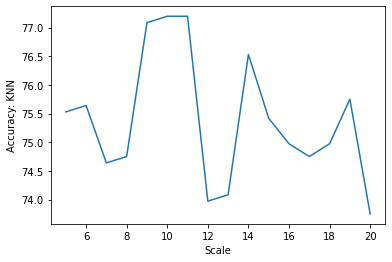

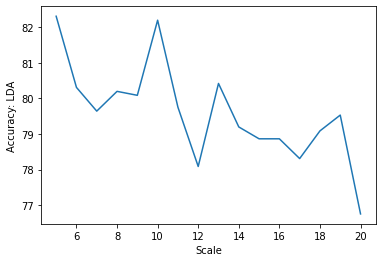

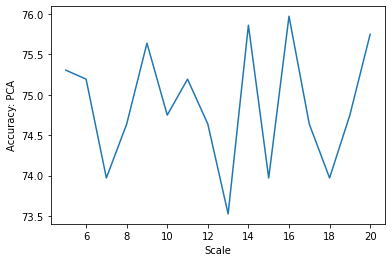

In [12]:
plt.plot(scales,total_knn_accuracy)
plt.ylabel('Accuracy: KNN')
plt.xlabel('Scale')
plt.show()

plt.plot(scales,total_lda_accuracy)
plt.ylabel('Accuracy: LDA')
plt.xlabel('Scale')
plt.show()

plt.plot(scales,total_pca_accuracy)
plt.ylabel('Accuracy: PCA')
plt.xlabel('Scale')
plt.show()

Now we execute the process with a normalization l2 in feature extraction:

In [19]:
train_images_filenames = cPickle.load(open('../Data/train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('../Data/test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('../Data/train_labels.dat','rb'))
test_labels = cPickle.load(open('../Data/test_labels.dat','rb'))

images,categories = construct_sets(train_images_filenames,test_images_filenames,train_labels,test_labels)

knn_accuracy_norm = []
lda_accuracy_norm = []
pca_accuracy_norm = []

SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=300)
for item,key in enumerate(images):
    Train_descriptors = []
    Train_label_per_descriptor = []
    if item == 0:
        train_filenames = images[0] + images[1]
        train_categories = categories[0] + categories[1]
        test_filenames = images[2]
        test_categories = categories[2]
    elif item == 1:
        train_ilenames = images[0] + images[2]
        train_categories = categories[0] + categories[2]
        test_filenames = images[1]
        test_categories = categories[1]
    else:
        train_filenames = images[1] + images[2]
        train_categories = categories[1] + categories[2]
        test_filenames = images[0]
        test_categories = categories[0]


    for filename,labels in zip(train_images_filenames,train_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kpt,des=SIFTdetector.detectAndCompute(gray,None)

        Train_descriptors.append(preprocessing.normalize(des, norm='l2'))
        Train_label_per_descriptor.append(labels)

    D=np.vstack(Train_descriptors)

    k = 128
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(D)

    visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
    for i in range(len(Train_descriptors)):
        words=codebook.predict(Train_descriptors[i])
        visual_words[i,:]=np.bincount(words,minlength=k)

    knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
    knn.fit(visual_words, train_labels)

    visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
    for i in range(len(test_images_filenames)):
        filename=test_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kpt,des=SIFTdetector.detectAndCompute(gray,None)
        words=codebook.predict(preprocessing.normalize(des, norm='l2'))
        visual_words_test[i,:]=np.bincount(words,minlength=k)

    accuracy = 100*knn.score(visual_words_test, test_labels)
    knn_accuracy_norm.append(accuracy)


    pca = PCA(n_components=64)
    VWpca = pca.fit_transform(visual_words)
    knnpca = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
    knnpca.fit(VWpca, train_labels)
    vwtestpca = pca.transform(visual_words_test)
    accuracy = 100*knnpca.score(vwtestpca, test_labels)
    pca_accuracy_norm.append(accuracy)

    lda = LinearDiscriminantAnalysis()
    VWlda = lda.fit_transform(visual_words,train_labels)
    knnlda = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
    knnlda.fit(VWlda, train_labels)
    vwtestlda = lda.transform(visual_words_test)
    accuracy = 100*knnlda.score(vwtestlda, test_labels)
    lda_accuracy_norm.append(accuracy)

Now we execute the process without l2 normalization in feature extraction to compare the results with l2 normalized
features.

In [21]:

train_images_filenames = cPickle.load(open('../Data/train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('../Data/test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('../Data/train_labels.dat','rb'))
test_labels = cPickle.load(open('../Data/test_labels.dat','rb'))

images,categories = construct_sets(train_images_filenames,test_images_filenames,train_labels,test_labels)

knn_accuracy = []
lda_accuracy = []
pca_accuracy = []

SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=300)
for item,key in enumerate(images):
    Train_descriptors = []
    Train_label_per_descriptor = []
    if item == 0:
        train_filenames = images[0] + images[1]
        train_categories = categories[0] + categories[1]
        test_filenames = images[2]
        test_categories = categories[2]
    elif item == 1:
        train_ilenames = images[0] + images[2]
        train_categories = categories[0] + categories[2]
        test_filenames = images[1]
        test_categories = categories[1]
    else:
        train_filenames = images[1] + images[2]
        train_categories = categories[1] + categories[2]
        test_filenames = images[0]
        test_categories = categories[0]


    for filename,labels in zip(train_images_filenames,train_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kpt,des=SIFTdetector.detectAndCompute(gray,None)

        Train_descriptors.append(des)
        Train_label_per_descriptor.append(labels)

    D=np.vstack(Train_descriptors)

    k = 128
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(D)

    visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
    for i in range(len(Train_descriptors)):
        words=codebook.predict(Train_descriptors[i])
        visual_words[i,:]=np.bincount(words,minlength=k)

    knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
    knn.fit(visual_words, train_labels)

    visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
    for i in range(len(test_images_filenames)):
        filename=test_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kpt,des=SIFTdetector.detectAndCompute(gray,None)
        words=codebook.predict(des)
        visual_words_test[i,:]=np.bincount(words,minlength=k)

    accuracy = 100*knn.score(visual_words_test, test_labels)
    knn_accuracy.append(accuracy)


    pca = PCA(n_components=64)
    VWpca = pca.fit_transform(visual_words)
    knnpca = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
    knnpca.fit(VWpca, train_labels)
    vwtestpca = pca.transform(visual_words_test)
    accuracy = 100*knnpca.score(vwtestpca, test_labels)
    pca_accuracy.append(accuracy)

    lda = LinearDiscriminantAnalysis()
    VWlda = lda.fit_transform(visual_words,train_labels)
    knnlda = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
    knnlda.fit(VWlda, train_labels)
    vwtestlda = lda.transform(visual_words_test)
    accuracy = 100*knnlda.score(vwtestlda, test_labels)
    lda_accuracy.append(accuracy)

At this moment we can compare the results between the normalized feature vectors and non-normalized features vectors.

In [22]:
knn = np.array(knn_accuracy)
lda = np.array(lda_accuracy)
pca = np.array(pca_accuracy)

knn = knn.mean()
lda = lda.mean()
pca = pca.mean()

knn_norm = np.array(knn_accuracy_norm)
lda_norm = np.array(lda_accuracy_norm)
pca_norm = np.array(lda_accuracy_norm)

knn_norm = knn_norm.mean()
lda_norm = lda_norm.mean()
pca_norm = pca_norm.mean()

Now, we print the results with feature extraction without normalization:

In [24]:
print("KNN Accuracy:" +str(knn))
print("PCA Accuracy:" +str(pca))
print("LDA Accuracy:" +str(lda))

KNN Accuracy:53.407682775712516
PCA Accuracy:54.399008674101616
LDA Accuracy:59.727385377943


Now, we print the results with feature extraction normalized:

In [25]:
print("KNN Accuracy:" +str(knn_norm))
print("PCA Accuracy:" +str(pca_norm))
print("LDA Accuracy:" +str(lda_norm))

KNN Accuracy:54.646840148698885
PCA Accuracy:58.48822800495663
LDA Accuracy:58.48822800495663


We can appreciate that the difference between normalized and non-normalized features its minimal

In [2]:
%reset -f
import cv2
import numpy as np
import time
import _pickle as cPickle
import random
from sklearn.svm import SVC
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from pykernels.basic import RBF, Linear
from pykernels.regular import Min # Histogram Intersection Kernel

train_images_filenames = cPickle.load(open('../Data/train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('../Data/test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('../Data/train_labels.dat','rb'))
test_labels = cPickle.load(open('../Data/test_labels.dat','rb'))

all_images_filenames = train_images_filenames + test_images_filenames
all_images_labels = train_labels+test_labels
categories = ['coast','forest','highway','inside_city','mountain','Opencountry','street','tallbuilding']

set1_filenames = []
set2_filenames = []
set3_filenames = []

set1_labels = []
set2_labels = []
set3_labels = []
c = list(zip(all_images_filenames, all_images_labels))
random.shuffle(c)
a,b = zip(*c)
for cat in categories:
    filename_matches = [s for s in all_images_filenames if cat in s]
    label_matches = [s for s in all_images_labels if cat in s]
    c = list(zip(filename_matches,label_matches))
    random.shuffle(c)
    filename_matches,label_matches = zip(*c)
    n_features = int(len(filename_matches)/3)

    set1_filenames.extend(filename_matches[0:n_features-1])
    set1_labels.extend(label_matches[0:n_features-1])

    set2_filenames.extend(filename_matches[n_features:(n_features * 2) - 1])
    set2_labels.extend(label_matches[n_features:(n_features * 2) - 1])

    set3_filenames.extend(filename_matches[n_features * 2:])
    set3_labels.extend(label_matches[n_features * 2:])

SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=300)

In [3]:
Train_descriptors = []
Train_label_per_descriptor = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kpt,des=SIFTdetector.detectAndCompute(gray,None)
    Train_descriptors.append(des)
    Train_label_per_descriptor.append(labels)

D=np.vstack(Train_descriptors)

k = 128
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
for i in range(len(Train_descriptors)):
    words=codebook.predict(Train_descriptors[i])
    visual_words[i,:]=np.bincount(words,minlength=k)

visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kpt,des=SIFTdetector.detectAndCompute(gray,None)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k)

In [4]:
svm_classifier=SVC()
svm_classifier.fit(visual_words, train_labels)
svm_classifier.predict(visual_words_test)

print("Default: %s" % (100*svm_classifier.score(visual_words_test, test_labels)))

Default: 67.53407682775713


In [5]:
rbf_svm_classifier=SVC(kernel=RBF(), C=1000)
rbf_svm_classifier.fit(visual_words, train_labels)
rbf_svm_classifier.predict(visual_words_test)
print("RBF Kernel: %s" % (100*rbf_svm_classifier.score(visual_words_test, test_labels)))

RBF Kernel: 42.00743494423792


In [6]:
histogram_svm_classifier=SVC(kernel=Min(), C=1000)
histogram_svm_classifier.fit(visual_words, train_labels)
histogram_svm_classifier.predict(visual_words_test)
print("Histogram Kernel: %s" % (100*histogram_svm_classifier.score(visual_words_test, test_labels)))

Histogram Kernel: 60.966542750929364


In [ ]:
linear_svm_classifier=SVC(kernel=Linear(), C=1000)
linear_svm_classifier.fit(visual_words, train_labels)
linear_svm_classifier.predict(visual_words_test)
print("Linear Kernel: %s" % (100*linear_svm_classifier.score(visual_words_test, test_labels)))

We can see in the current dataset the default kernel works better than the tested different kernels. Histogram Kernel is works better than RBF which is better than Linear